In [21]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Bloom Filter and Blocked Bloom Filter - FPR and mean query times

## Implementation details
- Implemented bloom filter and blocked bloom filter uses our own bit vectors
- We use `SeaHash` to hash our keys
- The bloom filters store required seeds for each hash function as private members
- The blocked bloom filter uses modular arithmetic to index into blocks
- **The implemented bloom filters are polymorphic! They can hash any object that implements the `Hash` trait in Rust**
- **The defined `MQ`, membership query trait, can be implemented by any exact or approximate MQ data structure in the future. Maybe someone will implement the quotient filter?**


## Most difficult portion of implementation/analysis
- Implementation was straightforward and relatively easy
- The analysis w.r.t 4 independent variables: # keys, theoretical FPR, bloom filter type, and insert/query scenario; and 2 dependent variables: empirical FPR, and mean query tim;  was tricky.

# Experimental setup
For each setting of # keys, $N$, and allowed FPR. We measure empirical FPR and query times of when 0%, 50% and 100% of the query set are in the bloom filter.

We vary the FPR from 1% to 25% in 10 even intervals.
We vary the expected number of elements from 1000 to 10 million log-uniformly.

In [22]:
results = pd.read_csv('bf_bench_results.tsv', header=0, sep='\t')

## Blocked vs vanilla bloom filter query time

**We analyze the results when the max FPR of the bloom filter and blocked bloom filter is set to 1%.**

Theoretically, the best case for improved locality of the blocked bloom filter (BBF) is when *all* the queried keys have already been inserted.

We plot the average query time of this scenario below. Here, the theory and empirical measurements agree. Clearly, the average query time of the BBF is less than that of the bloom filter (BF).

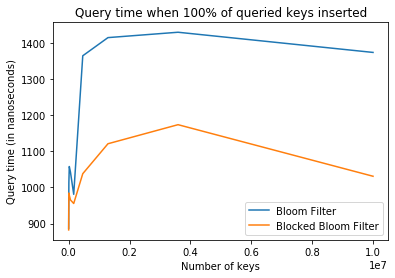

In [23]:
data =  results[(results.FPR == 0.01) & (results.frac_query_inserted == 1.0)]
plt.plot(data[data.amq=='bf'].N, data[data.amq=='bf'].query_time, label='Bloom Filter')
plt.plot(data[data.amq=='bbf'].N, data[data.amq=='bbf'].query_time, label='Blocked Bloom Filter')
plt.legend()
plt.title('Query time when 100% of queried keys inserted')
plt.xlabel('Number of keys')
plt.ylabel('Query time (in nanoseconds)')
plt.show()

However, when all queries are true negatives, the BBF has no advantage since both the BF and BBF both exit when the first false bit is found. Furthermore since the BBF has (in general) a higher FPR (as we will see later) the BBF spends more time hashing and looking up bits corresponding to false positives. Thus, in this scenaria, the BBF is slower than the BF across the board. (Note: the BBF also incurs some implementation overhead; modular arithmetic is expensive).

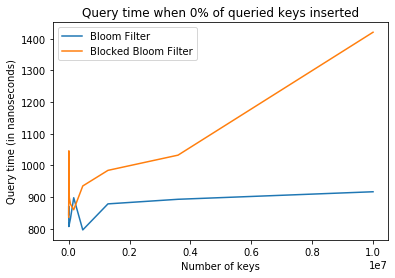

In [24]:
data =  results[(results.FPR == 0.01) & (results.frac_query_inserted == 0.0)]
plt.plot(data[data.amq=='bf'].N, data[data.amq=='bf'].query_time, label='Bloom Filter')
plt.plot(data[data.amq=='bbf'].N, data[data.amq=='bbf'].query_time, label='Blocked Bloom Filter')
plt.legend()
plt.title('Query time when 0% of queried keys inserted')
plt.xlabel('Number of keys')
plt.ylabel('Query time (in nanoseconds)')
plt.show()

When the proportion of true positives in the query set grows, the BBF can better leverage its improved locality when querying true positives. Below, we show that when 50% of the queried keys are true positives, the BBF is faster than the BF.

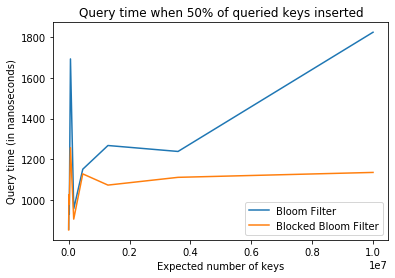

In [25]:
data =  results[(results.FPR == 0.01) & (results.frac_query_inserted == 0.5)]
plt.plot(data[data.amq=='bf'].N, data[data.amq=='bf'].query_time, label='Bloom Filter')
plt.plot(data[data.amq=='bbf'].N, data[data.amq=='bbf'].query_time, label='Blocked Bloom Filter')
plt.legend()
plt.title('Query time when 50% of queried keys inserted')
plt.xlabel('Expected number of keys')
plt.ylabel('Query time (in nanoseconds)')
plt.show()

We can also fix the expected number of elements and plot the query time vs maximum allowed FPR of the BF and BBF. When 50% of the queried keys are true positives, and the expected number of elements is 10 million, the BBF is faster than the BBF.

However, when the BBF has higher empirical FPR than the BF, it cannot exit early and returns false positives, and computes unecessary hashes. Thus, when the empirical FPR is higher than the BF, the average query time for the BBF can be higher or close to the BF. 

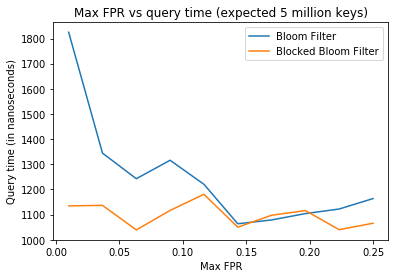

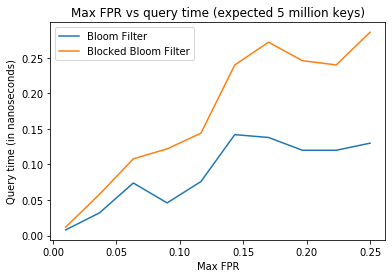

In [27]:
data =  results[(results.N == 10000000) & (results.frac_query_inserted == 0.5)]
plt.plot(data[data.amq=='bf'].FPR, data[data.amq=='bf'].query_time, label='Bloom Filter')
plt.plot(data[data.amq=='bbf'].FPR, data[data.amq=='bbf'].query_time, label='Blocked Bloom Filter')
plt.legend()
plt.title('Max FPR vs query time (expected 5 million keys)')
plt.xlabel('Max FPR')
plt.ylabel('Query time (in nanoseconds)')
plt.show()

plt.plot(data[data.amq=='bf'].FPR, data[data.amq=='bf'].empirical_FPR, label='Bloom Filter')
plt.plot(data[data.amq=='bbf'].FPR, data[data.amq=='bbf'].empirical_FPR, label='Blocked Bloom Filter')
plt.legend()
plt.title('Max FPR vs query time (expected 5 million keys)')
plt.xlabel('Max FPR')
plt.ylabel('Query time (in nanoseconds)')
plt.show()


It is important to notice that the BBF is only work using *if* a large proportion of queries are expected to be true positives. Otherwise, the BBF's improved locality when returned positives is rendered useless.

# FPR Analysis

We first plot the theoretical maximum FPR vs empirical FPR for all experiments.
- The BF is close to the theoretical FPR
- The BBF exceeds the theoretical FPR almost all the time

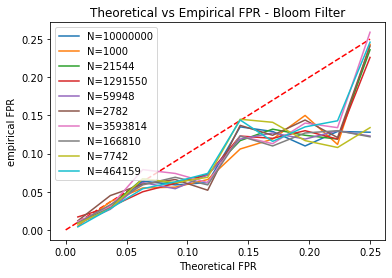

In [48]:
plt.plot([0, 0.25], [0., 0.25], 'r--')
for N in set(results.N):
    data = results[results.N == N]
    data = data[data.frac_query_inserted == 0.0]
    plt.plot(data[data.amq=='bf'].FPR, data[data.amq=='bf'].empirical_FPR, 
             label='N={}'.format(N))
    plt.xlabel("Theoretical FPR")
    plt.ylabel("empirical FPR")
    plt.legend()
    plt.title("Theoretical vs Empirical FPR - Bloom Filter")

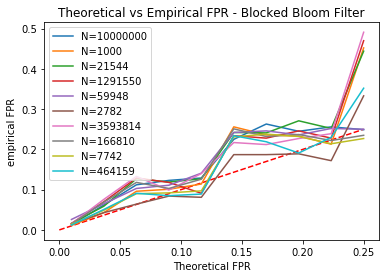

In [49]:
plt.plot([0, 0.25], [0., 0.25], 'r--')
for N in set(results.N):
    data = results[results.N == N]
    data = data[data.frac_query_inserted == 0.0]
    plt.plot(data[data.amq=='bbf'].FPR, data[data.amq=='bbf'].empirical_FPR, 
             label='N={}'.format(N))
    plt.xlabel("Theoretical FPR")
    plt.ylabel("empirical FPR")
    plt.legend()
    plt.title("Theoretical vs Empirical FPR - Blocked Bloom Filter")

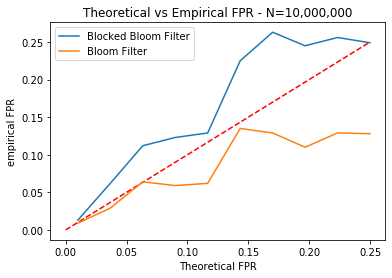

In [51]:
N = 10000000
data = results[results.N == N]
data = data[data.frac_query_inserted == 0.0]
plt.plot([0, 0.25], [0., 0.25], 'r--')
plt.plot(data[data.amq=='bbf'].FPR, data[data.amq=='bbf'].empirical_FPR, 
         label='Blocked Bloom Filter')
plt.plot(data[data.amq=='bf'].FPR, data[data.amq=='bf'].empirical_FPR, 
         label='Bloom Filter')
plt.xlabel("Theoretical FPR")
plt.ylabel("empirical FPR")
plt.legend()
_ = plt.title("Theoretical vs Empirical FPR - N=10,000,000")